In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "all_z"
key = "lambda"
quantile = "0"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  3.47it/s]

6it [00:00,  4.81it/s]

12it [00:00,  6.62it/s]

18it [00:00,  8.99it/s]

24it [00:00, 12.03it/s]

29it [00:00, 15.42it/s]

34it [00:00, 19.24it/s]

41it [00:01, 24.32it/s]

47it [00:01, 29.43it/s]

55it [00:01, 35.36it/s]

61it [00:01, 39.21it/s]

67it [00:01, 41.14it/s]

73it [00:01, 44.33it/s]

79it [00:01, 45.64it/s]

86it [00:01, 49.03it/s]

92it [00:01, 50.39it/s]

98it [00:02, 49.41it/s]

104it [00:02, 48.45it/s]

110it [00:02, 50.26it/s]

116it [00:02, 48.51it/s]

122it [00:02, 50.49it/s]

128it [00:02, 51.99it/s]

134it [00:02, 51.92it/s]

141it [00:02, 54.18it/s]

147it [00:03, 54.83it/s]

154it [00:03, 56.68it/s]

160it [00:03, 56.52it/s]

166it [00:03, 56.06it/s]

172it [00:03, 56.79it/s]

178it [00:03, 57.14it/s]

184it [00:03, 53.91it/s]

190it [00:03, 54.86it/s]

196it [00:03, 54.40it/s]

203it [00:04, 57.36it/s]

209it [00:04, 55.00it/s]

215it [00:04, 54.73it/s]

221it [00:04, 52.51it/s]

227it [00:04, 52.13it/s]

234it [00:04, 54.36it/s]

240it [00:04, 53.55it/s]

246it [00:04, 53.28it/s]

252it [00:04, 52.37it/s]

258it [00:05, 52.14it/s]

264it [00:05, 51.83it/s]

270it [00:05, 50.33it/s]

276it [00:05, 52.74it/s]

282it [00:05, 52.15it/s]

288it [00:05, 53.08it/s]

294it [00:05, 53.80it/s]

301it [00:05, 55.81it/s]

307it [00:05, 55.41it/s]

313it [00:06, 53.94it/s]

319it [00:06, 53.35it/s]

325it [00:06, 52.38it/s]

331it [00:06, 53.49it/s]

337it [00:06, 54.39it/s]

343it [00:06, 53.25it/s]

349it [00:06, 54.88it/s]

356it [00:06, 58.16it/s]

362it [00:06, 55.34it/s]

368it [00:07, 52.13it/s]

374it [00:07, 51.72it/s]

380it [00:07, 53.89it/s]

386it [00:07, 52.15it/s]

392it [00:07, 51.92it/s]

398it [00:07, 51.00it/s]

404it [00:07, 51.42it/s]

410it [00:07, 50.34it/s]

416it [00:08, 50.14it/s]

422it [00:08, 51.00it/s]

428it [00:08, 50.41it/s]

434it [00:08, 50.17it/s]

441it [00:08, 54.05it/s]

447it [00:08, 53.03it/s]

454it [00:08, 56.24it/s]

460it [00:08, 57.05it/s]

466it [00:08, 55.92it/s]

473it [00:09, 57.57it/s]

479it [00:09, 54.76it/s]

485it [00:09, 53.76it/s]

491it [00:09, 51.03it/s]

497it [00:09, 53.19it/s]

503it [00:09, 54.35it/s]

511it [00:09, 58.37it/s]

517it [00:09, 55.85it/s]

523it [00:09, 54.67it/s]

529it [00:10, 53.24it/s]

535it [00:10, 52.97it/s]

541it [00:10, 51.71it/s]

548it [00:10, 55.07it/s]

554it [00:10, 54.76it/s]

560it [00:10, 51.79it/s]

566it [00:10, 50.18it/s]

572it [00:10, 50.73it/s]

578it [00:11, 50.37it/s]

584it [00:11, 50.44it/s]

591it [00:11, 53.65it/s]

597it [00:11, 52.69it/s]

603it [00:11, 52.64it/s]

610it [00:11, 54.84it/s]

616it [00:11, 54.16it/s]

622it [00:11, 53.57it/s]

628it [00:11, 51.92it/s]

634it [00:12, 53.08it/s]

640it [00:12, 53.12it/s]

646it [00:12, 52.72it/s]

652it [00:12, 53.43it/s]

658it [00:12, 53.54it/s]

666it [00:12, 58.91it/s]

673it [00:12, 56.10it/s]

679it [00:12, 53.55it/s]

685it [00:13, 53.01it/s]

691it [00:13, 54.11it/s]

697it [00:13, 51.98it/s]

703it [00:13, 51.23it/s]

709it [00:13, 51.51it/s]

715it [00:13, 51.29it/s]

721it [00:13, 52.73it/s]

727it [00:13, 52.21it/s]

733it [00:13, 50.96it/s]

739it [00:14, 50.73it/s]

745it [00:14, 50.11it/s]

751it [00:14, 50.50it/s]

757it [00:14, 51.27it/s]

763it [00:14, 52.00it/s]

770it [00:14, 53.41it/s]

777it [00:14, 55.87it/s]

785it [00:14, 59.10it/s]

791it [00:15, 55.83it/s]

797it [00:15, 52.19it/s]

803it [00:15, 51.55it/s]

809it [00:15, 51.08it/s]

815it [00:15, 53.39it/s]

821it [00:15, 51.78it/s]

827it [00:15, 50.53it/s]

833it [00:15, 51.36it/s]

840it [00:15, 53.97it/s]

848it [00:16, 59.19it/s]

855it [00:16, 60.95it/s]

862it [00:16, 59.48it/s]

869it [00:16, 55.19it/s]

875it [00:16, 53.34it/s]

881it [00:16, 51.82it/s]

887it [00:16, 51.14it/s]

893it [00:16, 50.56it/s]

899it [00:17, 50.47it/s]

905it [00:17, 50.77it/s]

911it [00:17, 51.10it/s]

917it [00:17, 50.55it/s]

923it [00:17, 49.59it/s]

930it [00:17, 52.56it/s]

936it [00:17, 50.61it/s]

942it [00:17, 49.02it/s]

948it [00:18, 49.57it/s]

954it [00:18, 49.37it/s]

959it [00:18, 49.16it/s]

964it [00:18, 48.84it/s]

970it [00:18, 51.43it/s]

976it [00:18, 50.87it/s]

982it [00:18, 51.28it/s]

988it [00:18, 50.34it/s]

994it [00:18, 51.98it/s]

1000it [00:19, 52.76it/s]

1006it [00:19, 50.85it/s]

1012it [00:19, 52.40it/s]

1019it [00:19, 54.44it/s]

1025it [00:19, 52.78it/s]

1031it [00:19, 52.05it/s]

1038it [00:19, 56.02it/s]

1044it [00:19, 55.18it/s]

1051it [00:19, 58.12it/s]

1058it [00:20, 59.95it/s]

1066it [00:20, 61.72it/s]

1073it [00:20, 55.24it/s]

1079it [00:20, 54.11it/s]

1085it [00:20, 51.19it/s]

1091it [00:20, 50.82it/s]

1097it [00:20, 50.51it/s]

1103it [00:20, 50.67it/s]

1109it [00:21, 51.32it/s]

1115it [00:21, 48.93it/s]

1121it [00:21, 48.53it/s]

1126it [00:21, 45.94it/s]

1131it [00:21, 45.59it/s]

1136it [00:21, 43.75it/s]

1141it [00:21, 44.51it/s]

1146it [00:21, 43.79it/s]

1151it [00:22, 43.78it/s]

1156it [00:22, 44.72it/s]

1161it [00:22, 44.72it/s]

1166it [00:22, 45.62it/s]

1171it [00:22, 45.11it/s]

1176it [00:22, 45.67it/s]

1181it [00:22, 45.41it/s]

1186it [00:22, 44.92it/s]

1191it [00:22, 45.34it/s]

1196it [00:23, 44.08it/s]

1201it [00:23, 43.59it/s]

1206it [00:23, 44.79it/s]

1211it [00:23, 45.18it/s]

1216it [00:23, 45.10it/s]

1222it [00:23, 46.97it/s]

1228it [00:23, 47.61it/s]

1233it [00:23, 47.85it/s]

1238it [00:23, 45.09it/s]

1243it [00:24, 45.02it/s]

1248it [00:24, 45.59it/s]

1253it [00:24, 45.58it/s]

1258it [00:24, 46.68it/s]

1263it [00:24, 45.92it/s]

1268it [00:24, 44.83it/s]

1273it [00:24, 45.44it/s]

1278it [00:24, 46.61it/s]

1283it [00:24, 46.23it/s]

1290it [00:25, 50.16it/s]

1296it [00:25, 49.71it/s]

1302it [00:25, 50.45it/s]

1308it [00:25, 51.19it/s]

1314it [00:25, 49.85it/s]

1320it [00:25, 50.85it/s]

1327it [00:25, 53.47it/s]

1333it [00:25, 53.47it/s]

1339it [00:25, 50.52it/s]

1345it [00:26, 50.93it/s]

1351it [00:26, 51.55it/s]

1357it [00:26, 50.79it/s]

1363it [00:26, 50.72it/s]

1369it [00:26, 51.14it/s]

1375it [00:26, 50.06it/s]

1381it [00:26, 49.48it/s]

1388it [00:26, 53.27it/s]

1396it [00:27, 57.45it/s]

1403it [00:27, 58.92it/s]

1410it [00:27, 56.68it/s]

1416it [00:27, 54.38it/s]

1422it [00:27, 53.63it/s]

1428it [00:27, 55.27it/s]

1434it [00:27, 53.15it/s]

1440it [00:27, 51.50it/s]

1446it [00:27, 51.06it/s]

1452it [00:28, 53.07it/s]

1458it [00:28, 51.66it/s]

1464it [00:28, 49.71it/s]

1470it [00:28, 50.74it/s]

1476it [00:28, 52.40it/s]

1482it [00:28, 53.38it/s]

1488it [00:28, 53.33it/s]

1494it [00:28, 52.62it/s]

1500it [00:29, 50.51it/s]

1506it [00:29, 49.56it/s]

1512it [00:29, 49.66it/s]

1518it [00:29, 50.21it/s]

1524it [00:29, 51.36it/s]

1530it [00:29, 50.32it/s]

1536it [00:29, 49.62it/s]

1543it [00:29, 53.91it/s]

1549it [00:29, 51.84it/s]

1555it [00:30, 49.85it/s]

1561it [00:30, 51.69it/s]

1567it [00:30, 49.91it/s]

1573it [00:30, 49.67it/s]

1579it [00:30, 50.36it/s]

1585it [00:30, 50.99it/s]

1591it [00:30, 50.34it/s]

1597it [00:30, 51.78it/s]

1603it [00:31, 49.51it/s]

1609it [00:31, 51.17it/s]

1615it [00:31, 50.07it/s]

1621it [00:31, 49.84it/s]

1627it [00:31, 49.43it/s]

1632it [00:31, 48.65it/s]

1637it [00:31, 47.48it/s]

1642it [00:31, 46.35it/s]

1648it [00:31, 48.62it/s]

1654it [00:32, 51.13it/s]

1660it [00:32, 50.48it/s]

1666it [00:32, 50.60it/s]

1672it [00:32, 49.75it/s]

1678it [00:32, 48.76it/s]

1683it [00:32, 47.95it/s]

1688it [00:32, 48.34it/s]

1694it [00:32, 48.14it/s]

1699it [00:33, 48.60it/s]

1705it [00:33, 49.66it/s]

1711it [00:33, 50.25it/s]

1718it [00:33, 52.94it/s]

1724it [00:33, 51.65it/s]

1730it [00:33, 51.89it/s]

1736it [00:33, 53.76it/s]

1742it [00:33, 52.35it/s]

1748it [00:33, 51.42it/s]

1754it [00:34, 48.21it/s]

1760it [00:34, 50.62it/s]

1766it [00:34, 53.04it/s]

1772it [00:34, 53.58it/s]

1778it [00:34, 51.53it/s]

1784it [00:34, 53.69it/s]

1790it [00:34, 53.74it/s]

1796it [00:34, 51.30it/s]

1802it [00:35, 48.64it/s]

1809it [00:35, 52.45it/s]

1815it [00:35, 51.14it/s]

1821it [00:35, 50.60it/s]

1827it [00:35, 49.95it/s]

1833it [00:35, 49.26it/s]

1838it [00:35, 48.26it/s]

1845it [00:35, 51.33it/s]

1851it [00:35, 51.44it/s]

1857it [00:36, 52.18it/s]

1863it [00:36, 52.92it/s]

1869it [00:36, 50.66it/s]

1875it [00:36, 52.19it/s]

1881it [00:36, 49.15it/s]

1886it [00:36, 49.10it/s]

1892it [00:36, 50.42it/s]

1898it [00:36, 50.18it/s]

1904it [00:36, 52.23it/s]

1910it [00:37, 53.68it/s]

1916it [00:37, 55.19it/s]

1922it [00:37, 53.87it/s]

1928it [00:37, 53.44it/s]

1934it [00:37, 52.82it/s]

1940it [00:37, 52.59it/s]

1946it [00:37, 51.34it/s]

1952it [00:37, 50.15it/s]

1958it [00:38, 49.36it/s]

1964it [00:38, 49.57it/s]

1969it [00:38, 47.36it/s]

1976it [00:38, 50.84it/s]

1982it [00:38, 53.10it/s]

1988it [00:38, 53.19it/s]

1994it [00:38, 53.48it/s]

2000it [00:38, 54.31it/s]

2006it [00:38, 50.98it/s]

2013it [00:39, 53.71it/s]

2019it [00:39, 53.47it/s]

2025it [00:39, 50.39it/s]

2031it [00:39, 50.17it/s]

2037it [00:39, 51.67it/s]

2043it [00:39, 51.22it/s]

2049it [00:39, 50.15it/s]

2055it [00:39, 50.59it/s]

2061it [00:40, 50.82it/s]

2067it [00:40, 49.07it/s]

2074it [00:40, 52.52it/s]

2080it [00:40, 51.31it/s]

2086it [00:40, 50.33it/s]

2092it [00:40, 51.99it/s]

2098it [00:40, 50.15it/s]

2104it [00:40, 50.24it/s]

2110it [00:40, 51.44it/s]

2116it [00:41, 52.33it/s]

2122it [00:41, 52.17it/s]

2128it [00:41, 52.59it/s]

2134it [00:41, 50.23it/s]

2140it [00:41, 50.54it/s]

2147it [00:41, 53.65it/s]

2153it [00:41, 52.95it/s]

2159it [00:41, 53.96it/s]

2165it [00:42, 54.02it/s]

2171it [00:42, 55.16it/s]

2177it [00:42, 56.06it/s]

2184it [00:42, 57.32it/s]

2191it [00:42, 58.67it/s]

2197it [00:42, 58.94it/s]

2203it [00:42, 54.07it/s]

2209it [00:42, 52.23it/s]

2215it [00:42, 52.13it/s]

2221it [00:43, 50.11it/s]

2227it [00:43, 48.79it/s]

2232it [00:43, 48.69it/s]

2237it [00:43, 48.74it/s]

2242it [00:43, 48.19it/s]

2247it [00:43, 46.30it/s]

2254it [00:43, 50.78it/s]

2260it [00:43, 52.69it/s]

2267it [00:43, 55.86it/s]

2273it [00:44, 54.55it/s]

2279it [00:44, 50.68it/s]

2285it [00:44, 51.40it/s]

2291it [00:44, 52.24it/s]

2297it [00:44, 50.15it/s]

2303it [00:44, 48.94it/s]

2309it [00:44, 50.08it/s]

2315it [00:44, 51.25it/s]

2321it [00:45, 49.64it/s]

2327it [00:45, 50.24it/s]

2334it [00:45, 52.43it/s]

2340it [00:45, 51.57it/s]

2346it [00:45, 51.17it/s]

2352it [00:45, 50.02it/s]

2358it [00:45, 50.13it/s]

2365it [00:45, 53.66it/s]

2371it [00:45, 52.32it/s]

2377it [00:46, 50.61it/s]

2383it [00:46, 51.06it/s]

2389it [00:46, 52.16it/s]

2395it [00:46, 53.84it/s]

2401it [00:46, 54.74it/s]

2407it [00:46, 53.66it/s]

2413it [00:46, 55.29it/s]

2419it [00:46, 55.66it/s]

2425it [00:46, 54.92it/s]

2431it [00:47, 54.15it/s]

2437it [00:47, 52.84it/s]

2443it [00:47, 52.73it/s]

2449it [00:47, 51.40it/s]

2455it [00:47, 50.63it/s]

2461it [00:47, 49.19it/s]

2468it [00:47, 52.04it/s]

2474it [00:47, 52.54it/s]

2480it [00:48, 52.29it/s]

2487it [00:48, 55.03it/s]

2493it [00:48, 52.42it/s]

2499it [00:48, 50.43it/s]

2506it [00:48, 52.74it/s]

2512it [00:48, 52.25it/s]

2518it [00:48, 52.53it/s]

2524it [00:48, 51.70it/s]

2531it [00:48, 54.53it/s]

2537it [00:49, 52.37it/s]

2543it [00:49, 52.94it/s]

2549it [00:49, 52.25it/s]

2555it [00:49, 53.35it/s]

2562it [00:49, 55.52it/s]

2568it [00:49, 54.20it/s]

2574it [00:49, 53.56it/s]

2580it [00:49, 54.46it/s]

2586it [00:50, 52.26it/s]

2594it [00:50, 55.79it/s]

2601it [00:50, 58.01it/s]

2607it [00:50, 55.67it/s]

2613it [00:50, 56.33it/s]

2619it [00:50, 54.45it/s]

2625it [00:50, 54.23it/s]

2631it [00:50, 52.70it/s]

2637it [00:50, 51.23it/s]

2643it [00:51, 48.98it/s]

2649it [00:51, 49.86it/s]

2655it [00:51, 51.85it/s]

2661it [00:51, 52.72it/s]

2667it [00:51, 52.05it/s]

2673it [00:51, 51.74it/s]

2679it [00:51, 52.68it/s]

2685it [00:51, 52.05it/s]

2691it [00:51, 51.89it/s]

2697it [00:52, 50.59it/s]

2704it [00:52, 53.10it/s]

2710it [00:52, 54.47it/s]

2716it [00:52, 55.38it/s]

2722it [00:52, 54.07it/s]

2728it [00:52, 53.01it/s]

2735it [00:52, 55.31it/s]

2741it [00:52, 53.08it/s]

2747it [00:53, 51.04it/s]

2753it [00:53, 51.24it/s]

2760it [00:53, 53.94it/s]

2766it [00:53, 51.84it/s]

2772it [00:53, 50.03it/s]

2778it [00:53, 49.83it/s]

2784it [00:53, 50.95it/s]

2790it [00:53, 50.46it/s]

2796it [00:53, 52.06it/s]

2802it [00:54, 51.82it/s]

2808it [00:54, 50.81it/s]

2814it [00:54, 51.12it/s]

2820it [00:54, 51.96it/s]

2826it [00:54, 53.86it/s]

2832it [00:54, 52.63it/s]

2838it [00:54, 52.68it/s]

2844it [00:54, 53.28it/s]

2850it [00:55, 54.30it/s]

2856it [00:55, 54.14it/s]

2862it [00:55, 54.09it/s]

2868it [00:55, 53.27it/s]

2874it [00:55, 53.23it/s]

2880it [00:55, 53.13it/s]

2887it [00:55, 55.56it/s]

2894it [00:55, 57.48it/s]

2900it [00:55, 54.61it/s]

2906it [00:56, 54.46it/s]

2912it [00:56, 53.06it/s]

2918it [00:56, 53.59it/s]

2924it [00:56, 51.19it/s]

2930it [00:56, 53.33it/s]

2938it [00:56, 57.25it/s]

2944it [00:56, 56.78it/s]

2950it [00:56, 55.80it/s]

2956it [00:56, 53.61it/s]

2962it [00:57, 52.52it/s]

2968it [00:57, 54.26it/s]

2974it [00:57, 55.69it/s]

2980it [00:57, 53.27it/s]

2986it [00:57, 51.62it/s]

2993it [00:57, 55.66it/s]

3000it [00:57, 56.92it/s]

3007it [00:57, 57.43it/s]

3013it [00:57, 55.75it/s]

3019it [00:58, 55.69it/s]

3025it [00:58, 54.59it/s]

3031it [00:58, 53.40it/s]

3037it [00:58, 52.30it/s]

3043it [00:58, 54.22it/s]

3049it [00:58, 55.83it/s]

3055it [00:58, 56.80it/s]

3061it [00:58, 57.04it/s]

3068it [00:58, 59.45it/s]

3075it [00:59, 61.41it/s]

3082it [00:59, 60.64it/s]

3089it [00:59, 58.56it/s]

3095it [00:59, 53.88it/s]

3101it [00:59, 53.07it/s]

3107it [00:59, 50.15it/s]

3113it [00:59, 49.36it/s]

3118it [00:59, 48.33it/s]

3124it [01:00, 50.90it/s]

3130it [01:00, 51.63it/s]

3136it [01:00, 50.32it/s]

3142it [01:00, 52.08it/s]

3148it [01:00, 50.05it/s]

3154it [01:00, 50.11it/s]

3160it [01:00, 51.04it/s]

3166it [01:00, 51.98it/s]

3173it [01:00, 54.61it/s]

3179it [01:01, 52.87it/s]

3185it [01:01, 49.43it/s]

3191it [01:01, 50.95it/s]

3197it [01:01, 50.69it/s]

3203it [01:01, 50.34it/s]

3209it [01:01, 52.03it/s]

3215it [01:01, 53.23it/s]

3221it [01:01, 51.96it/s]

3227it [01:02, 51.96it/s]

3233it [01:02, 51.46it/s]

3239it [01:02, 53.27it/s]

3245it [01:02, 51.31it/s]

3251it [01:02, 50.40it/s]

3258it [01:02, 53.21it/s]

3264it [01:02, 53.60it/s]

3270it [01:02, 51.33it/s]

3276it [01:02, 52.61it/s]

3282it [01:03, 53.10it/s]

3289it [01:03, 55.57it/s]

3295it [01:03, 56.35it/s]

3301it [01:03, 56.25it/s]

3307it [01:03, 56.99it/s]

3313it [01:03, 56.21it/s]

3319it [01:03, 55.09it/s]

3325it [01:03, 56.28it/s]

3331it [01:03, 53.56it/s]

3337it [01:04, 54.36it/s]

3343it [01:04, 51.29it/s]

3349it [01:04, 50.49it/s]

3356it [01:04, 53.30it/s]

3362it [01:04, 52.60it/s]

3368it [01:04, 52.70it/s]

3374it [01:04, 51.25it/s]

3380it [01:04, 50.46it/s]

3386it [01:05, 50.39it/s]

3392it [01:05, 50.92it/s]

3398it [01:05, 52.06it/s]

3404it [01:05, 53.13it/s]

3410it [01:05, 54.46it/s]

3416it [01:05, 55.98it/s]

3422it [01:05, 54.35it/s]

3428it [01:05, 53.55it/s]

3435it [01:05, 54.84it/s]

3441it [01:06, 52.60it/s]

3447it [01:06, 54.60it/s]

3453it [01:06, 53.25it/s]

3459it [01:06, 49.96it/s]

3465it [01:06, 52.35it/s]

3471it [01:06, 51.69it/s]

3477it [01:06, 52.83it/s]

3484it [01:06, 55.65it/s]

3490it [01:06, 56.01it/s]

3496it [01:07, 54.54it/s]

3502it [01:07, 52.06it/s]

3508it [01:07, 52.64it/s]

3514it [01:07, 52.74it/s]

3521it [01:07, 55.33it/s]

3527it [01:07, 55.52it/s]

3533it [01:07, 54.21it/s]

3539it [01:07, 52.25it/s]

3545it [01:07, 50.24it/s]

3551it [01:08, 50.61it/s]

3557it [01:08, 49.22it/s]

3562it [01:08, 48.21it/s]

3568it [01:08, 49.83it/s]

3574it [01:08, 48.94it/s]

3580it [01:08, 49.70it/s]

3587it [01:08, 52.29it/s]

3593it [01:08, 51.66it/s]

3599it [01:09, 51.85it/s]

3605it [01:09, 53.30it/s]

3611it [01:09, 51.79it/s]

3617it [01:09, 49.35it/s]

3623it [01:09, 51.68it/s]

3631it [01:09, 56.86it/s]

3637it [01:09, 54.61it/s]

3643it [01:09, 54.97it/s]

3649it [01:09, 52.07it/s]

3655it [01:10, 51.52it/s]

3661it [01:10, 53.04it/s]

3667it [01:10, 52.54it/s]

3673it [01:10, 53.51it/s]

3680it [01:10, 56.27it/s]

3686it [01:10, 53.93it/s]

3692it [01:10, 51.29it/s]

3698it [01:10, 50.14it/s]

3704it [01:11, 50.56it/s]

3710it [01:11, 50.83it/s]

3716it [01:11, 51.29it/s]

3722it [01:11, 51.34it/s]

3728it [01:11, 50.65it/s]

3734it [01:11, 52.92it/s]

3740it [01:11, 51.95it/s]

3746it [01:11, 51.84it/s]

3752it [01:11, 53.29it/s]

3758it [01:12, 54.95it/s]

3764it [01:12, 52.98it/s]

3770it [01:12, 52.89it/s]

3776it [01:12, 53.21it/s]

3783it [01:12, 55.30it/s]

3789it [01:12, 55.99it/s]

3795it [01:12, 54.40it/s]

3801it [01:12, 52.44it/s]

3807it [01:12, 53.67it/s]

3813it [01:13, 52.64it/s]

3819it [01:13, 53.18it/s]

3825it [01:13, 52.91it/s]

3832it [01:13, 53.96it/s]

3838it [01:13, 53.39it/s]

3844it [01:13, 55.01it/s]

3850it [01:13, 52.57it/s]

3856it [01:13, 50.85it/s]

3863it [01:14, 53.41it/s]

3869it [01:14, 51.94it/s]

3875it [01:14, 51.19it/s]

3881it [01:14, 53.20it/s]

3887it [01:14, 53.33it/s]

3893it [01:14, 53.01it/s]

3899it [01:14, 49.83it/s]

3905it [01:14, 50.85it/s]

3912it [01:14, 53.21it/s]

3918it [01:15, 54.96it/s]

3924it [01:15, 53.84it/s]

3930it [01:15, 50.85it/s]

3936it [01:15, 51.17it/s]

3942it [01:15, 52.10it/s]

3948it [01:15, 51.88it/s]

3954it [01:15, 51.44it/s]

3960it [01:15, 51.40it/s]

3966it [01:15, 52.33it/s]

3972it [01:16, 51.25it/s]

3978it [01:16, 50.83it/s]

3984it [01:16, 51.26it/s]

3990it [01:16, 50.09it/s]

3997it [01:16, 52.80it/s]

4003it [01:16, 52.00it/s]

4009it [01:16, 51.45it/s]

4015it [01:16, 52.53it/s]

4021it [01:17, 51.53it/s]

4028it [01:17, 55.55it/s]

4035it [01:17, 56.85it/s]

4041it [01:17, 54.78it/s]

4047it [01:17, 54.08it/s]

4053it [01:17, 53.49it/s]

4059it [01:17, 54.39it/s]

4065it [01:17, 54.58it/s]

4071it [01:17, 55.35it/s]

4078it [01:18, 58.62it/s]

4085it [01:18, 59.11it/s]

4091it [01:18, 54.68it/s]

4097it [01:18, 52.06it/s]

4103it [01:18, 50.54it/s]

4110it [01:18, 54.37it/s]

4116it [01:18, 51.62it/s]

4122it [01:18, 50.57it/s]

4128it [01:19, 49.27it/s]

4129it [01:19, 52.22it/s]


0it [00:00, ?it/s]

5it [00:00, 49.64it/s]

Number of empty sat catalogs is 7


11it [00:00, 50.74it/s]

17it [00:00, 51.00it/s]

22it [00:00, 50.52it/s]

28it [00:00, 51.70it/s]

33it [00:00, 50.85it/s]

39it [00:00, 51.87it/s]

46it [00:00, 54.18it/s]

52it [00:00, 51.84it/s]

58it [00:01, 52.06it/s]

64it [00:01, 51.26it/s]

70it [00:01, 51.89it/s]

76it [00:01, 51.14it/s]

83it [00:01, 53.53it/s]

89it [00:01, 53.13it/s]

95it [00:01, 54.49it/s]

101it [00:01, 52.70it/s]

107it [00:02, 51.33it/s]

113it [00:02, 51.85it/s]

119it [00:02, 50.15it/s]

125it [00:02, 48.47it/s]

130it [00:02, 48.52it/s]

136it [00:02, 49.37it/s]

142it [00:02, 49.94it/s]

148it [00:02, 52.20it/s]

154it [00:02, 52.42it/s]

160it [00:03, 51.52it/s]

166it [00:03, 52.07it/s]

172it [00:03, 52.38it/s]

178it [00:03, 49.94it/s]

184it [00:03, 50.21it/s]

190it [00:03, 49.85it/s]

196it [00:03, 52.11it/s]

202it [00:03, 53.71it/s]

208it [00:04, 53.79it/s]

215it [00:04, 56.31it/s]

221it [00:04, 55.77it/s]

227it [00:04, 52.09it/s]

233it [00:04, 51.19it/s]

239it [00:04, 50.74it/s]

245it [00:04, 51.02it/s]

251it [00:04, 51.22it/s]

257it [00:04, 50.88it/s]

264it [00:05, 53.13it/s]

270it [00:05, 51.50it/s]

276it [00:05, 51.62it/s]

282it [00:05, 50.69it/s]

288it [00:05, 51.24it/s]

294it [00:05, 50.11it/s]

301it [00:05, 54.67it/s]

307it [00:05, 52.57it/s]

313it [00:06, 54.49it/s]

319it [00:06, 55.78it/s]

325it [00:06, 55.22it/s]

331it [00:06, 55.63it/s]

337it [00:06, 54.09it/s]

343it [00:06, 53.81it/s]

349it [00:06, 54.26it/s]

355it [00:06, 51.87it/s]

361it [00:06, 52.34it/s]

367it [00:07, 50.36it/s]

373it [00:07, 50.05it/s]

379it [00:07, 52.10it/s]

386it [00:07, 55.30it/s]

392it [00:07, 52.69it/s]

398it [00:07, 52.56it/s]

404it [00:07, 54.11it/s]

410it [00:07, 54.36it/s]

416it [00:07, 54.00it/s]

422it [00:08, 54.81it/s]

428it [00:08, 56.01it/s]

434it [00:08, 56.38it/s]

440it [00:08, 56.74it/s]

446it [00:08, 56.01it/s]

453it [00:08, 57.57it/s]

459it [00:08, 54.48it/s]

465it [00:08, 54.80it/s]

471it [00:08, 52.73it/s]

477it [00:09, 51.62it/s]

483it [00:09, 51.92it/s]

491it [00:09, 56.47it/s]

497it [00:09, 55.08it/s]

504it [00:09, 56.95it/s]

510it [00:09, 57.82it/s]

516it [00:09, 54.40it/s]

522it [00:09, 54.37it/s]

528it [00:09, 52.77it/s]

534it [00:10, 51.71it/s]

540it [00:10, 50.00it/s]

546it [00:10, 51.33it/s]

552it [00:10, 53.51it/s]

558it [00:10, 53.58it/s]

564it [00:10, 52.69it/s]

570it [00:10, 54.37it/s]

576it [00:10, 53.22it/s]

582it [00:10, 52.38it/s]

588it [00:11, 51.91it/s]

594it [00:11, 50.88it/s]

600it [00:11, 51.13it/s]

606it [00:11, 50.02it/s]

612it [00:11, 48.69it/s]

618it [00:11, 49.06it/s]

624it [00:11, 50.03it/s]

630it [00:11, 50.16it/s]

636it [00:12, 51.33it/s]

642it [00:12, 50.05it/s]

648it [00:12, 49.12it/s]

653it [00:12, 48.83it/s]

659it [00:12, 49.55it/s]

664it [00:12, 48.61it/s]

671it [00:12, 51.92it/s]

678it [00:12, 54.93it/s]

684it [00:12, 53.66it/s]

690it [00:13, 52.00it/s]

696it [00:13, 51.16it/s]

702it [00:13, 51.90it/s]

708it [00:13, 51.44it/s]

714it [00:13, 48.91it/s]

719it [00:13, 47.97it/s]

724it [00:13, 48.18it/s]

730it [00:13, 49.75it/s]

736it [00:14, 51.29it/s]

742it [00:14, 50.95it/s]

748it [00:14, 51.07it/s]

754it [00:14, 49.67it/s]

760it [00:14, 50.46it/s]

766it [00:14, 50.51it/s]

772it [00:14, 48.91it/s]

778it [00:14, 49.60it/s]

784it [00:15, 50.25it/s]

790it [00:15, 50.67it/s]

796it [00:15, 49.96it/s]

802it [00:15, 49.33it/s]

808it [00:15, 50.46it/s]

814it [00:15, 51.15it/s]

820it [00:15, 50.18it/s]

826it [00:15, 52.22it/s]

832it [00:15, 52.51it/s]

838it [00:16, 41.79it/s]

845it [00:16, 46.27it/s]

852it [00:16, 49.90it/s]

861it [00:16, 55.71it/s]

868it [00:16, 53.97it/s]

874it [00:16, 54.22it/s]

880it [00:16, 51.99it/s]

886it [00:16, 51.88it/s]

892it [00:17, 51.41it/s]

900it [00:17, 55.60it/s]

906it [00:17, 53.24it/s]

912it [00:17, 53.03it/s]

918it [00:17, 53.84it/s]

924it [00:17, 52.62it/s]

931it [00:17, 55.14it/s]

937it [00:17, 54.72it/s]

943it [00:18, 55.53it/s]

949it [00:18, 55.50it/s]

955it [00:18, 55.50it/s]

963it [00:18, 59.56it/s]

970it [00:18, 59.09it/s]

976it [00:18, 58.53it/s]

982it [00:18, 55.36it/s]

988it [00:18, 52.51it/s]

994it [00:18, 54.32it/s]

1001it [00:19, 56.12it/s]

1007it [00:19, 55.26it/s]

1013it [00:19, 55.56it/s]

1019it [00:19, 54.65it/s]

1025it [00:19, 54.20it/s]

1032it [00:19, 56.36it/s]

1038it [00:19, 56.46it/s]

1044it [00:19, 54.14it/s]

1050it [00:19, 53.86it/s]

1056it [00:20, 53.53it/s]

1062it [00:20, 53.92it/s]

1068it [00:20, 53.04it/s]

1074it [00:20, 51.82it/s]

1080it [00:20, 52.30it/s]

1086it [00:20, 51.99it/s]

1092it [00:20, 53.21it/s]

1098it [00:20, 53.32it/s]

1104it [00:20, 53.92it/s]

1110it [00:21, 54.12it/s]

1116it [00:21, 52.21it/s]

1122it [00:21, 52.33it/s]

1128it [00:21, 51.03it/s]

1134it [00:21, 52.27it/s]

1140it [00:21, 51.62it/s]

1146it [00:21, 48.53it/s]

1152it [00:21, 50.05it/s]

1158it [00:22, 52.01it/s]

1164it [00:22, 51.51it/s]

1170it [00:22, 51.52it/s]

1176it [00:22, 51.98it/s]

1182it [00:22, 50.94it/s]

1188it [00:22, 50.38it/s]

1194it [00:22, 50.71it/s]

1200it [00:22, 50.14it/s]

1206it [00:22, 48.87it/s]

1212it [00:23, 49.30it/s]

1218it [00:23, 50.42it/s]

1224it [00:23, 50.36it/s]

1230it [00:23, 51.02it/s]

1236it [00:23, 51.12it/s]

1242it [00:23, 51.99it/s]

1248it [00:23, 51.71it/s]

1254it [00:23, 52.39it/s]

1260it [00:24, 51.60it/s]

1266it [00:24, 52.81it/s]

1272it [00:24, 54.31it/s]

1279it [00:24, 57.98it/s]

1285it [00:24, 57.43it/s]

1291it [00:24, 54.55it/s]

1298it [00:24, 56.92it/s]

1306it [00:24, 60.16it/s]

1313it [00:24, 57.37it/s]

1319it [00:25, 55.85it/s]

1325it [00:25, 56.06it/s]

1331it [00:25, 54.40it/s]

1337it [00:25, 53.67it/s]

1343it [00:25, 54.75it/s]

1349it [00:25, 56.12it/s]

1355it [00:25, 55.70it/s]

1361it [00:25, 55.52it/s]

1367it [00:25, 53.64it/s]

1373it [00:26, 52.21it/s]

1379it [00:26, 52.10it/s]

1385it [00:26, 52.13it/s]

1392it [00:26, 56.14it/s]

1398it [00:26, 56.64it/s]

1405it [00:26, 58.64it/s]

1411it [00:26, 56.25it/s]

1417it [00:26, 56.45it/s]

1423it [00:26, 53.15it/s]

1429it [00:27, 52.14it/s]

1435it [00:27, 50.28it/s]

1441it [00:27, 50.43it/s]

1447it [00:27, 49.18it/s]

1452it [00:27, 49.00it/s]

1457it [00:27, 48.62it/s]

1463it [00:27, 50.15it/s]

1469it [00:27, 48.44it/s]

1475it [00:28, 49.54it/s]

1481it [00:28, 51.75it/s]

1487it [00:28, 52.44it/s]

1493it [00:28, 53.01it/s]

1499it [00:28, 54.74it/s]

1507it [00:28, 58.56it/s]

1513it [00:28, 54.27it/s]

1519it [00:28, 55.31it/s]

1525it [00:28, 53.65it/s]

1531it [00:29, 52.46it/s]

1537it [00:29, 52.48it/s]

1543it [00:29, 51.28it/s]

1549it [00:29, 51.31it/s]

1556it [00:29, 54.22it/s]

1562it [00:29, 53.87it/s]

1568it [00:29, 51.79it/s]

1574it [00:29, 49.37it/s]

1580it [00:29, 51.29it/s]

1586it [00:30, 51.00it/s]

1592it [00:30, 50.71it/s]

1598it [00:30, 53.15it/s]

1604it [00:30, 52.06it/s]

1611it [00:30, 55.17it/s]

1617it [00:30, 54.35it/s]

1623it [00:30, 55.70it/s]

1629it [00:30, 55.13it/s]

1635it [00:30, 55.06it/s]

1642it [00:31, 57.99it/s]

1648it [00:31, 56.94it/s]

1654it [00:31, 55.26it/s]

1660it [00:31, 54.58it/s]

1666it [00:31, 54.67it/s]

1672it [00:31, 55.14it/s]

1678it [00:31, 55.89it/s]

1684it [00:31, 57.00it/s]

1690it [00:31, 56.03it/s]

1696it [00:32, 54.71it/s]

1706it [00:32, 63.18it/s]

1713it [00:32, 62.14it/s]

1720it [00:32, 60.25it/s]

1727it [00:32, 60.58it/s]

1734it [00:32, 61.10it/s]

1741it [00:32, 61.61it/s]

1748it [00:32, 62.00it/s]

1755it [00:32, 62.34it/s]

1769it [00:33, 74.15it/s]

1783it [00:33, 85.78it/s]

1796it [00:33, 94.83it/s]

1807it [00:33, 81.94it/s]

1820it [00:33, 91.75it/s]

1833it [00:33, 98.97it/s]

1846it [00:33, 105.51it/s]

1859it [00:33, 111.43it/s]

1872it [00:33, 116.00it/s]

1886it [00:34, 121.02it/s]

1900it [00:34, 124.42it/s]

1913it [00:34, 109.38it/s]

1926it [00:34, 114.04it/s]

1940it [00:34, 118.26it/s]

1953it [00:34, 121.40it/s]

1966it [00:34, 123.60it/s]

1980it [00:34, 125.50it/s]

1993it [00:34, 126.39it/s]

2006it [00:35, 126.57it/s]

2019it [00:35, 127.40it/s]

2033it [00:35, 128.00it/s]

2046it [00:35, 127.84it/s]

2059it [00:35, 126.97it/s]

2072it [00:35, 126.23it/s]

2085it [00:35, 127.32it/s]

2099it [00:35, 128.25it/s]

2112it [00:35, 128.64it/s]

2125it [00:35, 125.07it/s]

2138it [00:36, 125.14it/s]

2151it [00:36, 126.11it/s]

2164it [00:36, 125.72it/s]

2177it [00:36, 126.33it/s]

2190it [00:36, 126.39it/s]

2203it [00:36, 122.62it/s]

2216it [00:36, 124.29it/s]

2229it [00:36, 124.54it/s]

2242it [00:36, 125.75it/s]

2255it [00:37, 125.76it/s]

2268it [00:37, 126.19it/s]

2281it [00:37, 119.70it/s]

2294it [00:37, 121.57it/s]

2307it [00:37, 122.37it/s]

2320it [00:37, 123.53it/s]

2333it [00:37, 119.52it/s]

2346it [00:37, 113.60it/s]

2359it [00:37, 117.96it/s]

2372it [00:38, 120.94it/s]

2386it [00:38, 124.20it/s]

2399it [00:38, 124.36it/s]

2412it [00:38, 106.20it/s]

2424it [00:38, 107.94it/s]

2438it [00:38, 113.66it/s]

2452it [00:38, 118.50it/s]

2465it [00:38, 107.02it/s]

2477it [00:38, 108.23it/s]

2490it [00:39, 112.73it/s]

2503it [00:39, 113.81it/s]

2515it [00:39, 107.11it/s]

2529it [00:39, 113.47it/s]

2542it [00:39, 117.68it/s]

2555it [00:39, 120.82it/s]

2569it [00:39, 123.86it/s]

2582it [00:39, 125.47it/s]

2595it [00:39, 120.67it/s]

2608it [00:40, 122.63it/s]

2622it [00:40, 124.93it/s]

2636it [00:40, 126.55it/s]

2650it [00:40, 128.13it/s]

2663it [00:40, 121.60it/s]

2676it [00:40, 123.58it/s]

2689it [00:40, 125.44it/s]

2702it [00:40, 125.51it/s]

2715it [00:40, 126.29it/s]

2729it [00:40, 127.74it/s]

2742it [00:41, 125.81it/s]

2755it [00:41, 123.94it/s]

2768it [00:41, 118.92it/s]

2780it [00:41, 112.88it/s]

2794it [00:41, 117.66it/s]

2808it [00:41, 121.09it/s]

2821it [00:41, 120.32it/s]

2834it [00:41, 121.47it/s]

2847it [00:41, 121.77it/s]

2860it [00:42, 122.36it/s]

2873it [00:42, 123.11it/s]

2886it [00:42, 119.63it/s]

2899it [00:42, 120.96it/s]

2912it [00:42, 122.38it/s]

2925it [00:42, 123.15it/s]

2938it [00:42, 123.26it/s]

2951it [00:42, 120.41it/s]

2965it [00:42, 123.31it/s]

2978it [00:43, 124.89it/s]

2991it [00:43, 125.85it/s]

3004it [00:43, 126.94it/s]

3017it [00:43, 126.99it/s]

3030it [00:43, 127.30it/s]

3043it [00:43, 128.02it/s]

3057it [00:43, 128.61it/s]

3071it [00:43, 129.22it/s]

3084it [00:43, 129.16it/s]

3097it [00:43, 127.58it/s]

3110it [00:44, 127.26it/s]

3123it [00:44, 112.13it/s]

3135it [00:44, 106.57it/s]

3147it [00:44, 109.45it/s]

3159it [00:44, 108.93it/s]

3171it [00:44, 102.00it/s]

3182it [00:44, 97.88it/s] 

3192it [00:44, 94.98it/s]

3202it [00:45, 91.91it/s]

3212it [00:45, 88.97it/s]

3222it [00:45, 88.45it/s]

3231it [00:45, 77.83it/s]

3240it [00:45, 80.46it/s]

3249it [00:45, 81.87it/s]

3262it [00:45, 90.60it/s]

3275it [00:45, 98.04it/s]

3287it [00:45, 103.54it/s]

3299it [00:46, 107.76it/s]

3312it [00:46, 111.52it/s]

3325it [00:46, 114.29it/s]

3338it [00:46, 116.63it/s]

3350it [00:46, 117.02it/s]

3363it [00:46, 118.36it/s]

3376it [00:46, 119.16it/s]

3388it [00:46, 118.84it/s]

3400it [00:46, 118.29it/s]

3412it [00:46, 118.71it/s]

3425it [00:47, 119.49it/s]

3437it [00:47, 119.62it/s]

3449it [00:47, 109.32it/s]

3461it [00:47, 111.08it/s]

3473it [00:47, 113.24it/s]

3485it [00:47, 113.86it/s]

3497it [00:47, 115.30it/s]

3509it [00:47, 116.00it/s]

3522it [00:47, 117.12it/s]

3534it [00:48, 116.90it/s]

3546it [00:48, 117.28it/s]

3559it [00:48, 118.90it/s]

3572it [00:48, 121.50it/s]

3585it [00:48, 123.03it/s]

3598it [00:48, 124.52it/s]

3611it [00:48, 125.39it/s]

3624it [00:48, 126.10it/s]

3637it [00:48, 126.80it/s]

3650it [00:48, 126.63it/s]

3663it [00:49, 127.17it/s]

3676it [00:49, 127.33it/s]

3689it [00:49, 123.80it/s]

3702it [00:49, 124.95it/s]

3715it [00:49, 118.54it/s]

3727it [00:49, 118.34it/s]

3740it [00:49, 119.61it/s]

3753it [00:49, 120.90it/s]

3766it [00:49, 120.96it/s]

3779it [00:50, 119.93it/s]

3792it [00:50, 120.24it/s]

3805it [00:50, 119.56it/s]

3817it [00:50, 117.37it/s]

3829it [00:50, 115.35it/s]

3841it [00:50, 116.70it/s]

3854it [00:50, 117.73it/s]

3866it [00:50, 117.70it/s]

3878it [00:50, 116.79it/s]

3891it [00:50, 119.65it/s]

3904it [00:51, 121.24it/s]

3917it [00:51, 122.57it/s]

3930it [00:51, 123.95it/s]

3943it [00:51, 123.94it/s]

3956it [00:51, 125.17it/s]

3969it [00:51, 126.46it/s]

3982it [00:51, 121.89it/s]

3996it [00:51, 124.65it/s]

4009it [00:51, 124.99it/s]

4022it [00:52, 126.44it/s]

4035it [00:52, 126.22it/s]

4048it [00:52, 126.44it/s]

4061it [00:52, 120.90it/s]

4074it [00:52, 122.48it/s]

4087it [00:52, 124.03it/s]

4100it [00:52, 119.97it/s]

4113it [00:52, 122.57it/s]

4126it [00:52, 123.40it/s]

4129it [00:52, 78.03it/s] 

Number of empty sat catalogs is 7


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

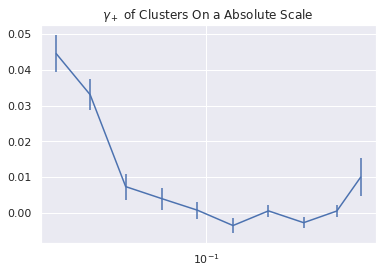

Aggregated xi:
[-19.8734 -28.1092 -10.1818  -8.6018  -2.7629  21.3393  -4.4679  27.6829
  -3.9609  -8.2841]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1926.9968  -3285.2445  -4711.3501  -6299.936   -9335.0439 -11568.9223
 -12527.9275  -9879.4591  -4430.8501   -187.9415]
------------------------------------------------------------------------------
Aggregated npairs:
[ 446.  850. 1391. 2170. 3853. 5953. 8543. 9950. 8109.  831.]
------------------------------------------------------------------------------
Mean xi:
[-0.0446 -0.0331 -0.0073 -0.004  -0.0007  0.0036 -0.0005  0.0028 -0.0005
 -0.01  ]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3206 -3.865  -3.387  -2.9032 -2.4228 -1.9434 -1.4665 -0.9929 -0.5464
 -0.2262]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

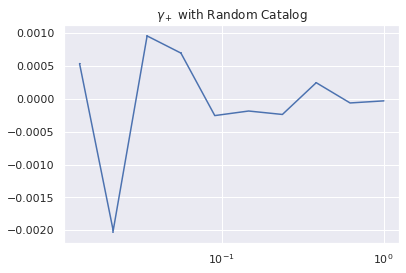

[ 5.3807e-04 -2.0032e-03  9.5860e-04  6.9755e-04 -2.5362e-04 -1.8407e-04
 -2.3639e-04  2.4706e-04 -6.1347e-05 -2.9438e-05]
[-8.3736e-06  3.1174e-05 -1.4918e-05 -1.0856e-05  3.9469e-06  2.8646e-06
  3.6787e-06 -3.8449e-06  9.5470e-07  4.5812e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

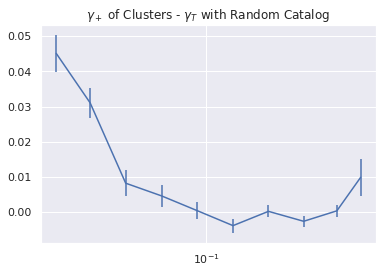

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

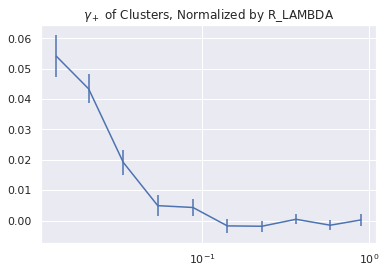

Aggregated xi:
[-10.6146 -25.8639 -19.6456  -7.8193 -11.4338   7.8208  12.6242  -3.8099
  15.452   -1.0777]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -844.5105 -2302.7127 -3471.4453 -4635.9061 -6444.2284 -8698.5864
 -9951.4163 -9209.0657 -5406.6303  -681.1263]
------------------------------------------------------------------------------
Aggregated npairs:
[  196.   596.  1025.  1592.  2655.  4451.  6727.  9128. 10074.  5747.]
------------------------------------------------------------------------------
Mean xi:
[-0.0542 -0.0434 -0.0192 -0.0049 -0.0043  0.0018  0.0019 -0.0004  0.0015
 -0.0002]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3087 -3.8636 -3.3868 -2.912  -2.4272 -1.9543 -1.4793 -1.0089 -0.5367
 -0.1185]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)